In [6]:
#Q-LEARNING ALGORITHM TAKEN FROM https://github.com/MJeremy2017/reinforcement-learning-implementation
#COMMENTED AREAS WITH -- ARE SECTIONS THAT I HAVE CHANGED

import numpy as np
import copy

#--Set board to be 10x10
BOARD_ROWS = 10
BOARD_COLS = 10
#--Set win state as ratio 7:9
WIN_STATE = (6, 8)
#--Add lose states where portfolio is not diversified enough
LOSE_STATES = [(0,5),(0,6),(0,7),(0,8),(0,9),(5,0),(6,0),(7,0),(8,0),(9,0)]
#--Set start portfolio, with ratio 1:2
START = (0, 1)
#--Perform 10000 iterations of the game
ITERATIONS = 10000

class State:
    def __init__(self, state=START):
        self.state = state
        self.isEnd = False

    def giveReward(self):
        #--Rewards for ending in each situation
        if self.state == WIN_STATE:
            return 50
        elif self.state in LOSE_STATES:
            return -50
        else:
            return -2

    def isEndFunc(self):
        #--Check if the agent has arrived at a terminal state
        if (self.state == WIN_STATE) or (self.state in LOSE_STATES):
            self.isEnd = True

    def nxtPosition(self, action):
        """
        action: up, down, left, right
        -------------
        0 | 1 | 2| 3|
        1 |
        2 |
        return next position on board
        """
        #--I have removed their non-deterministic method since having an epsilon-greedy algorithm does the same thing
        if action == "up":
            nxtState = (self.state[0] - 1, self.state[1])
        elif action == "down":
            nxtState = (self.state[0] + 1, self.state[1])
        elif action == "left":
            nxtState = (self.state[0], self.state[1] - 1)
        else:
            nxtState = (self.state[0], self.state[1] + 1)


        # if next state is legal
        if (nxtState[0] >= 0) and (nxtState[0] <= BOARD_ROWS - 1):
            if (nxtState[1] >= 0) and (nxtState[1] <= BOARD_COLS - 1):
                #--Updated so that you can return to the starting portfolio position
                return nxtState
        return self.state

class Agent:

    def __init__(self):
        self.states = []  # record position and action taken at the position
        self.actions = ["up", "down", "left", "right"]
        self.State = State()
        self.isEnd = self.State.isEnd
        self.lr = 0.2
        self.exp_rate = 0.3
        self.decay_gamma = 0.9

        # initial Q values
        self.Q_values = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.Q_values[(i, j)] = {}
                for a in self.actions:
                    self.Q_values[(i, j)][a] = 0  # Q value is a dict of dict

    def chooseAction(self, iteration):
        # choose action with most expected value
        mx_nxt_reward = -10000
        action = ""

        #--Add decaying epsilon so that as the agent learns, it is less likely to choose a random action
        #--This decay is linear
        if np.random.uniform(0, 1) <= self.exp_rate * (ITERATIONS-iteration)/ITERATIONS:
            action = np.random.choice(self.actions)
        else:
            # greedy action
            for a in self.actions:
                current_position = self.State.state
                nxt_reward = self.Q_values[current_position][a]
                if nxt_reward >= mx_nxt_reward:
                    action = a
                    mx_nxt_reward = nxt_reward
        return action

    def takeAction(self, action):
        position = self.State.nxtPosition(action)
        # update State
        return State(state=position)

    def reset(self):
        self.states = []
        self.State = State()
        self.isEnd = self.State.isEnd

    def play(self):
        i = 0

        #--Store rewards, move number, and Q-values for each iteration
        reward_memory = ITERATIONS*[0]
        move_no_memory = ITERATIONS*[0]
        Q_memory = ITERATIONS*[0]

        while i < ITERATIONS:
            # to the end of game back propagate reward
            if self.State.isEnd:
                # back propagate
                reward = self.State.giveReward()
                for a in self.actions:
                    self.Q_values[self.State.state][a] = reward

                #--Add to memory
                reward_memory[i] = reward
                move_no_memory[i] = len(self.states)

                for s in reversed(self.states):
                    #--When testing this code, I encountered an error where an action would not be selected
                    #--I believe I fixed it, but the try-catch has been left just in case
                    try:
                        current_q_value = self.Q_values[s[0]][s[1]]
                    except:
                        print(self.states)
                        print("Error game")
                        pass
                    
                    #--Updated reward to also include -2 per move - this encourages completion in the least amount of moves
                    reward = current_q_value + self.lr * (-2 + self.decay_gamma * reward - current_q_value)
                    self.Q_values[s[0]][s[1]] = round(reward, 3)
                
                #--Add to memory
                #--Needs to be a deep copy otherwise the array will all be the final Q-value
                Q_memory[i] = copy.deepcopy(self.Q_values)
                
                self.reset()
                i += 1
            else:
                action = self.chooseAction(iteration = i)
                # append trace
                self.states.append([(self.State.state), action])

                # by taking the action, it reaches the next state
                self.State = self.takeAction(action)
                # mark is end
                self.State.isEndFunc()
                
                self.isEnd = self.State.isEnd
        return [reward_memory, move_no_memory, Q_memory]

In [7]:
if __name__ == "__main__":
    ag = Agent()
    [reward_memory, move_no_memory, Q_memory] = ag.play()

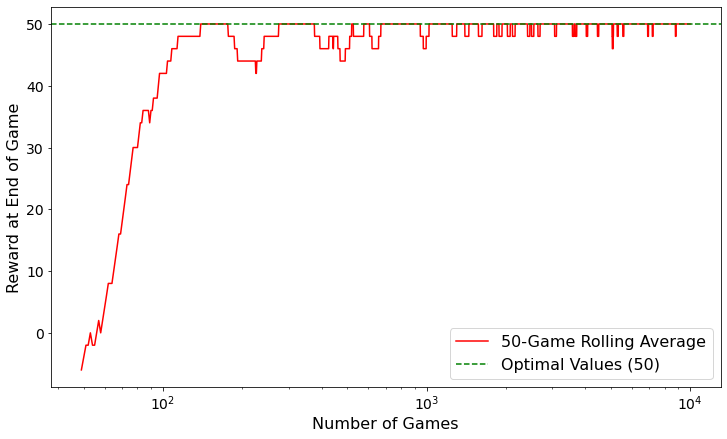

In [12]:
#THIS CODE IS NOW ALL ORIGINAL

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

#Create dataframe of rewards
reward_df = pd.DataFrame(reward_memory)
#Calculate rolling mean
reward_mean = reward_df.rolling(50).mean()

#Plot the graph
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 
fig1,ax1 = plt.subplots(figsize=[12,7])
ax1.plot(reward_df.index, reward_mean, "r")
ax1.set_xlabel("Number of Games", fontsize=16)
ax1.set_ylabel("Reward at End of Game", fontsize=16)
ax1.set_xscale("log")
plt.axhline(y=50, color='g', linestyle='--')
plt.legend(["50-Game Rolling Average", "Optimal Values (50)"], fontsize=16)
plt.savefig("Reward Mean.png")

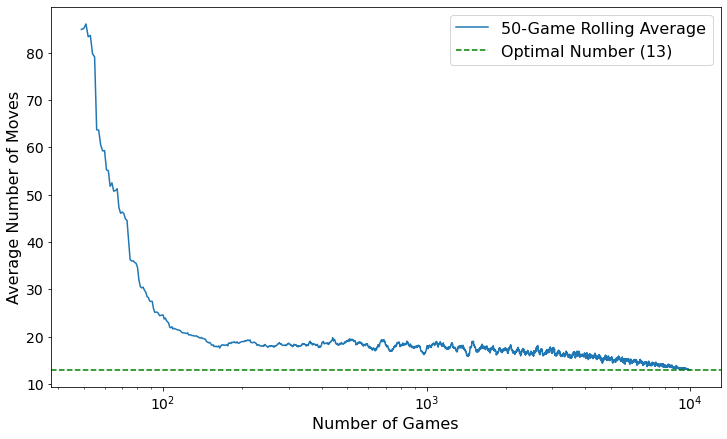

In [13]:
#Create dataframe for move number
move_df = pd.DataFrame(move_no_memory)
#Calculate average
move_mean = move_df.rolling(50).mean()

#Plot graph
fig2,ax2 = plt.subplots(figsize=[12,7])
ax2.plot(move_df.index,move_mean)
ax2.set_xscale("log")
plt.axhline(y=13, color='g', linestyle='--')

plt.legend(["50-Game Rolling Average","Optimal Number (13)"], fontsize = 16)
ax2.set_xlabel("Number of Games", fontsize=16)
ax2.set_ylabel("Average Number of Moves", fontsize=16)

plt.savefig("Move Mean.png")

In [14]:
v_memory_10 = {}
v_memory_100 = {}
v_memory_last = {}

#Calculate the value function for each state by summing the action-value functions over actions
#Perform this for the 10th, 100th, and last iteration
for key in Q_memory[9]:
    v_memory_10[key] = round(sum(Q_memory[10][key].values())/4,3)
for key in Q_memory[99]:
    v_memory_100[key] = round(sum(Q_memory[100][key].values())/4,3)
for key in Q_memory[-1]:
    v_memory_last[key] = round(sum(Q_memory[-1][key].values())/4,3)

#Print the values to the terminal
def print_values(v_memory):
    v_memory_csv = ""
    for i in reversed(range(0,BOARD_ROWS)):
        row = "|"
        print("--------------------------------------------------------------")
        for j in range(0,BOARD_COLS):
            row += str(v_memory[(i, j)]).ljust(7) + ' | '
            #Add to csv file entry
            v_memory_csv += str(v_memory[(i,j)])+","
        print(row)
        v_memory_csv += "\n"
    print("--------------------------------------------------------------")
    return v_memory_csv

#Print out information and save to csv
print("After 10 Iterations:")
v_data_10 = print_values(v_memory_10)
with open("V 10.csv", "w") as f:
    f.write(v_data_10)

print("After 100 Iterations:")
v_data_100 = print_values(v_memory_100)
with open("V 100.csv", "w") as f:
    f.write(v_data_100)

v_data_last = print_values(v_memory_last)
with open("V last.csv", "w") as f:
    f.write(v_data_last)

After 10 Iterations:
--------------------------------------------------------------
|0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 
--------------------------------------------------------------
|0.0     | 0.0     | 0.0     | 0.0     | -0.122  | -0.122  | -0.122  | -0.278  | -0.306  | -0.892  | 
--------------------------------------------------------------
|0.0     | 0.0     | -0.426  | -1.002  | -1.805  | -1.798  | -0.17   | 0.159   | -0.328  | -0.084  | 
--------------------------------------------------------------
|0.0     | -1.512  | -2.177  | -1.359  | -0.121  | -0.416  | -0.122  | 2.15    | 50.0    | 2.63    | 
--------------------------------------------------------------
|-50.0   | -3.32   | -1.454  | -1.42   | -0.255  | -0.254  | -0.293  | -0.303  | 0.737   | -3.837  | 
--------------------------------------------------------------
|-7.384  | -2.55   | -1.852  | -2.042  | -0.509  | -0.226  | -0.396  | -0.473  | -1.07   | 